# 论文5：通过最小化描述长度保持神经网络简单
## Hinton & Van Camp (1993) + 现代剪枝技术

### 网络剪枝与压缩

关键洞察：移除不必要的权重以获得更简单、更泛化的网络。越小越好！

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 用于分类的简单神经网络

In [2]:
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

class SimpleNN:
    """Simple 2-layer neural network"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Initialize weights
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.1
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.1
        self.b2 = np.zeros(output_dim)
        
        # Keep track of masks for pruning
        self.mask1 = np.ones_like(self.W1)
        self.mask2 = np.ones_like(self.W2)
    
    def forward(self, X):
        """Forward pass"""
        # Apply masks (for pruned weights)
        W1_masked = self.W1 * self.mask1
        W2_masked = self.W2 * self.mask2
        
        # Hidden layer
        self.h = relu(np.dot(X, W1_masked) + self.b1)
        
        # Output layer
        logits = np.dot(self.h, W2_masked) + self.b2
        probs = softmax(logits)
        
        return probs
    
    def predict(self, X):
        """Predict class labels"""
        probs = self.forward(X)
        return np.argmax(probs, axis=1)
    
    def accuracy(self, X, y):
        """Compute accuracy"""
        predictions = self.predict(X)
        return np.mean(predictions == y)
    
    def count_parameters(self):
        """Count total and active (non-pruned) parameters"""
        total = self.W1.size + self.b1.size + self.W2.size + self.b2.size
        active = int(np.sum(self.mask1) + self.b1.size + np.sum(self.mask2) + self.b2.size)
        return total, active

# Test network
nn = SimpleNN(input_dim=10, hidden_dim=20, output_dim=3)
X_test = np.random.randn(5, 10)
y_test = nn.forward(X_test)
print(f"Network output shape: {y_test.shape}")
total, active = nn.count_parameters()
print(f"Parameters: {total} total, {active} active")

Network output shape: (5, 3)
Parameters: 283 total, 283 active


## 生成合成数据集

In [3]:
def generate_classification_data(n_samples=1000, n_features=20, n_classes=3):
    """
    Generate synthetic classification dataset
    Each class is a Gaussian blob
    """
    X = []
    y = []
    
    samples_per_class = n_samples // n_classes
    
    for c in range(n_classes):
        # Random center for this class
        center = np.random.randn(n_features) * 3
        
        # Generate samples around center
        X_class = np.random.randn(samples_per_class, n_features) + center
        y_class = np.full(samples_per_class, c)
        
        X.append(X_class)
        y.append(y_class)
    
    X = np.vstack(X)
    y = np.concatenate(y)
    
    # Shuffle
    indices = np.random.permutation(len(X))
    X = X[indices]
    y = y[indices]
    
    return X, y

# Generate data
X_train, y_train = generate_classification_data(n_samples=1000, n_features=20, n_classes=3)
X_test, y_test = generate_classification_data(n_samples=300, n_features=20, n_classes=3)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print(f"Class distribution: {np.bincount(y_train)}")

Training set: (999, 20), (999,)
Test set: (300, 20), (300,)
Class distribution: [333 333 333]


## 训练基线网络

In [4]:
def train_network(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.01):
    """
    Simple training loop
    """
    train_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Forward pass
        probs = model.forward(X_train)
        
        # Cross-entropy loss
        y_one_hot = np.zeros((len(y_train), model.output_dim))
        y_one_hot[np.arange(len(y_train)), y_train] = 1
        loss = -np.mean(np.sum(y_one_hot * np.log(probs + 1e-8), axis=1))
        
        # Backward pass (simplified)
        batch_size = len(X_train)
        dL_dlogits = (probs - y_one_hot) / batch_size
        
        # Gradients for W2, b2
        dL_dW2 = np.dot(model.h.T, dL_dlogits)
        dL_db2 = np.sum(dL_dlogits, axis=0)
        
        # Gradients for W1, b1
        dL_dh = np.dot(dL_dlogits, (model.W2 * model.mask2).T)
        dL_dh[model.h <= 0] = 0  # ReLU derivative
        dL_dW1 = np.dot(X_train.T, dL_dh)
        dL_db1 = np.sum(dL_dh, axis=0)
        
        # Update weights (only where mask is active)
        model.W1 -= lr * dL_dW1 * model.mask1
        model.b1 -= lr * dL_db1
        model.W2 -= lr * dL_dW2 * model.mask2
        model.b2 -= lr * dL_db2
        
        # Track metrics
        train_losses.append(loss)
        test_acc = model.accuracy(X_test, y_test)
        test_accuracies.append(test_acc)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}, Test Acc: {test_acc:.2%}")
    
    return train_losses, test_accuracies

# Train baseline model
print("Training baseline network...\n")
baseline_model = SimpleNN(input_dim=20, hidden_dim=50, output_dim=3)
train_losses, test_accs = train_network(baseline_model, X_train, y_train, X_test, y_test, epochs=100)

baseline_acc = baseline_model.accuracy(X_test, y_test)
total_params, active_params = baseline_model.count_parameters()
print(f"\nBaseline: {baseline_acc:.2%} accuracy, {active_params} parameters")

Training baseline network...

Epoch 20/100, Loss: 0.1641, Test Acc: 63.67%
Epoch 40/100, Loss: 0.0760, Test Acc: 64.67%
Epoch 60/100, Loss: 0.0471, Test Acc: 65.67%
Epoch 80/100, Loss: 0.0334, Test Acc: 66.33%
Epoch 100/100, Loss: 0.0256, Test Acc: 67.00%

Baseline: 67.00% accuracy, 1203 parameters


## 基于幅度的剪枝

移除具有最小绝对值的权重

In [5]:
def prune_by_magnitude(model, pruning_rate):
    """
    Prune weights with smallest magnitudes
    
    pruning_rate: fraction of weights to remove (0-1)
    """
    # Collect all weights
    all_weights = np.concatenate([model.W1.flatten(), model.W2.flatten()])
    all_magnitudes = np.abs(all_weights)
    
    # Find threshold
    threshold = np.percentile(all_magnitudes, pruning_rate * 100)
    
    # Create new masks
    model.mask1 = (np.abs(model.W1) > threshold).astype(float)
    model.mask2 = (np.abs(model.W2) > threshold).astype(float)
    
    print(f"Pruning threshold: {threshold:.6f}")
    print(f"Pruned {pruning_rate:.1%} of weights")
    
    total, active = model.count_parameters()
    print(f"Remaining parameters: {active}/{total} ({active/total:.1%})")

# Test pruning
import copy
pruned_model = copy.deepcopy(baseline_model)

print("Before pruning:")
acc_before = pruned_model.accuracy(X_test, y_test)
print(f"Accuracy: {acc_before:.2%}\n")

print("Pruning 50% of weights...")
prune_by_magnitude(pruned_model, pruning_rate=0.5)

print("\nAfter pruning (before retraining):")
acc_after = pruned_model.accuracy(X_test, y_test)
print(f"Accuracy: {acc_after:.2%}")
print(f"Accuracy drop: {(acc_before - acc_after):.2%}")

Before pruning:
Accuracy: 67.00%

Pruning 50% of weights...
Pruning threshold: 0.068908
Pruned 50.0% of weights
Remaining parameters: 628/1203 (52.2%)

After pruning (before retraining):
Accuracy: 70.00%
Accuracy drop: -3.00%


## 剪枝后微调

重新训练剩余权重以恢复准确率

In [6]:
print("Fine-tuning pruned network...\n")
finetune_losses, finetune_accs = train_network(
    pruned_model, X_train, y_train, X_test, y_test, epochs=50, lr=0.005
)

acc_finetuned = pruned_model.accuracy(X_test, y_test)
total, active = pruned_model.count_parameters()

print(f"\n{'='*60}")
print("RESULTS:")
print(f"{'='*60}")
print(f"Baseline:     {baseline_acc:.2%} accuracy, {total_params} params")
print(f"Pruned 50%:   {acc_finetuned:.2%} accuracy, {active} params")
print(f"Compression:  {total_params/active:.1f}x smaller")
print(f"Acc. change:  {(acc_finetuned - baseline_acc):+.2%}")
print(f"{'='*60}")

Fine-tuning pruned network...

Epoch 20/50, Loss: 0.0467, Test Acc: 68.67%
Epoch 40/50, Loss: 0.0408, Test Acc: 68.67%

RESULTS:
Baseline:     67.00% accuracy, 1203 params
Pruned 50%:   68.33% accuracy, 628 params
Compression:  1.9x smaller
Acc. change:  +1.33%


## 迭代剪枝

逐渐增加剪枝率

In [7]:
def iterative_pruning(model, X_train, y_train, X_test, y_test, 
                     target_sparsity=0.9, num_iterations=5):
    """
    Iteratively prune and finetune
    """
    results = []
    
    # Initial state
    total, active = model.count_parameters()
    acc = model.accuracy(X_test, y_test)
    results.append({
        'iteration': 0,
        'sparsity': 0.0,
        'active_params': active,
        'accuracy': acc
    })
    
    # Gradually increase sparsity
    for i in range(num_iterations):
        # Sparsity for this iteration
        current_sparsity = target_sparsity * (i + 1) / num_iterations
        
        print(f"\nIteration {i+1}/{num_iterations}: Target sparsity {current_sparsity:.1%}")
        
        # Prune
        prune_by_magnitude(model, pruning_rate=current_sparsity)
        
        # Finetune
        train_network(model, X_train, y_train, X_test, y_test, epochs=30, lr=0.005)
        
        # Record results
        total, active = model.count_parameters()
        acc = model.accuracy(X_test, y_test)
        results.append({
            'iteration': i + 1,
            'sparsity': current_sparsity,
            'active_params': active,
            'accuracy': acc
        })
    
    return results

# Run iterative pruning
iterative_model = copy.deepcopy(baseline_model)
results = iterative_pruning(iterative_model, X_train, y_train, X_test, y_test, 
                           target_sparsity=0.95, num_iterations=5)


Iteration 1/5: Target sparsity 19.0%
Pruning threshold: 0.023685
Pruned 19.0% of weights
Remaining parameters: 984/1203 (81.8%)
Epoch 20/30, Loss: 0.0245, Test Acc: 68.00%

Iteration 2/5: Target sparsity 38.0%
Pruning threshold: 0.052205
Pruned 38.0% of weights
Remaining parameters: 766/1203 (63.7%)
Epoch 20/30, Loss: 0.0296, Test Acc: 67.33%

Iteration 3/5: Target sparsity 57.0%
Pruning threshold: 0.082052
Pruned 57.0% of weights
Remaining parameters: 548/1203 (45.6%)
Epoch 20/30, Loss: 0.0425, Test Acc: 63.00%

Iteration 4/5: Target sparsity 76.0%
Pruning threshold: 0.126976
Pruned 76.0% of weights
Remaining parameters: 329/1203 (27.3%)
Epoch 20/30, Loss: 0.0749, Test Acc: 39.33%

Iteration 5/5: Target sparsity 95.0%
Pruning threshold: 0.219937
Pruned 95.0% of weights
Remaining parameters: 111/1203 (9.2%)
Epoch 20/30, Loss: 0.8688, Test Acc: 47.00%


## 可视化剪枝结果

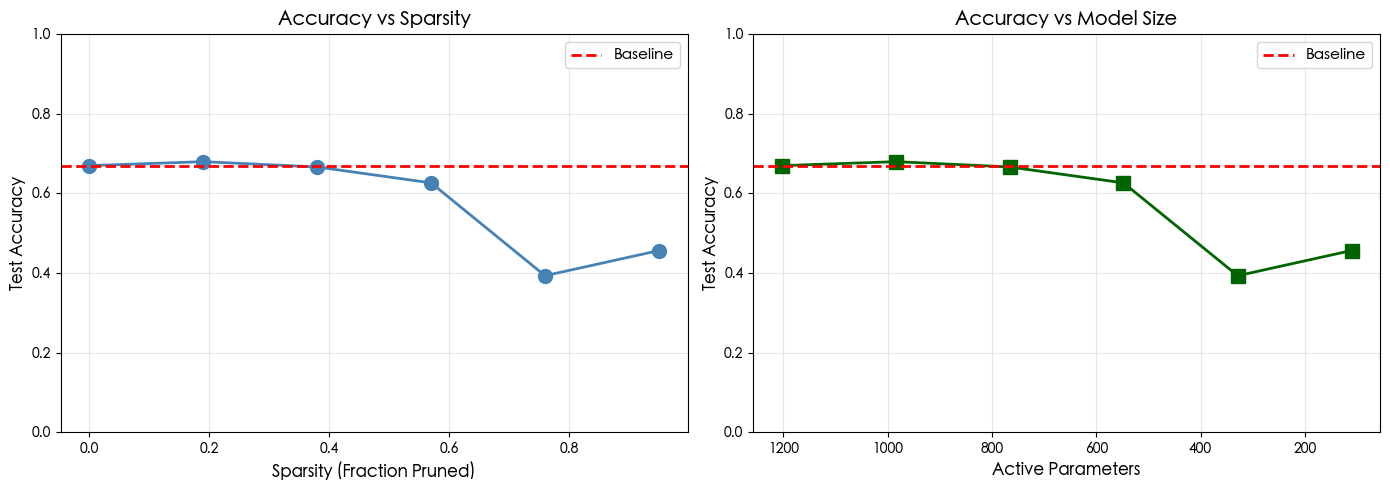


Key observation: Can remove 90%+ of weights with minimal accuracy loss!


In [8]:
# Extract data
sparsities = [r['sparsity'] for r in results]
accuracies = [r['accuracy'] for r in results]
active_params = [r['active_params'] for r in results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy vs Sparsity
ax1.plot(sparsities, accuracies, 'o-', linewidth=2, markersize=10, color='steelblue')
ax1.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, label='Baseline')
ax1.set_xlabel('Sparsity (Fraction Pruned)', fontsize=12)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Accuracy vs Sparsity', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_ylim([0, 1])

# Parameters vs Accuracy
ax2.plot(active_params, accuracies, 's-', linewidth=2, markersize=10, color='darkgreen')
ax2.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, label='Baseline')
ax2.set_xlabel('Active Parameters', fontsize=12)
ax2.set_ylabel('Test Accuracy', fontsize=12)
ax2.set_title('Accuracy vs Model Size', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)
ax2.set_ylim([0, 1])
ax2.invert_xaxis()  # Fewer params on right

plt.tight_layout()
plt.show()

print("\nKey observation: Can remove 90%+ of weights with minimal accuracy loss!")

## 可视化权重分布

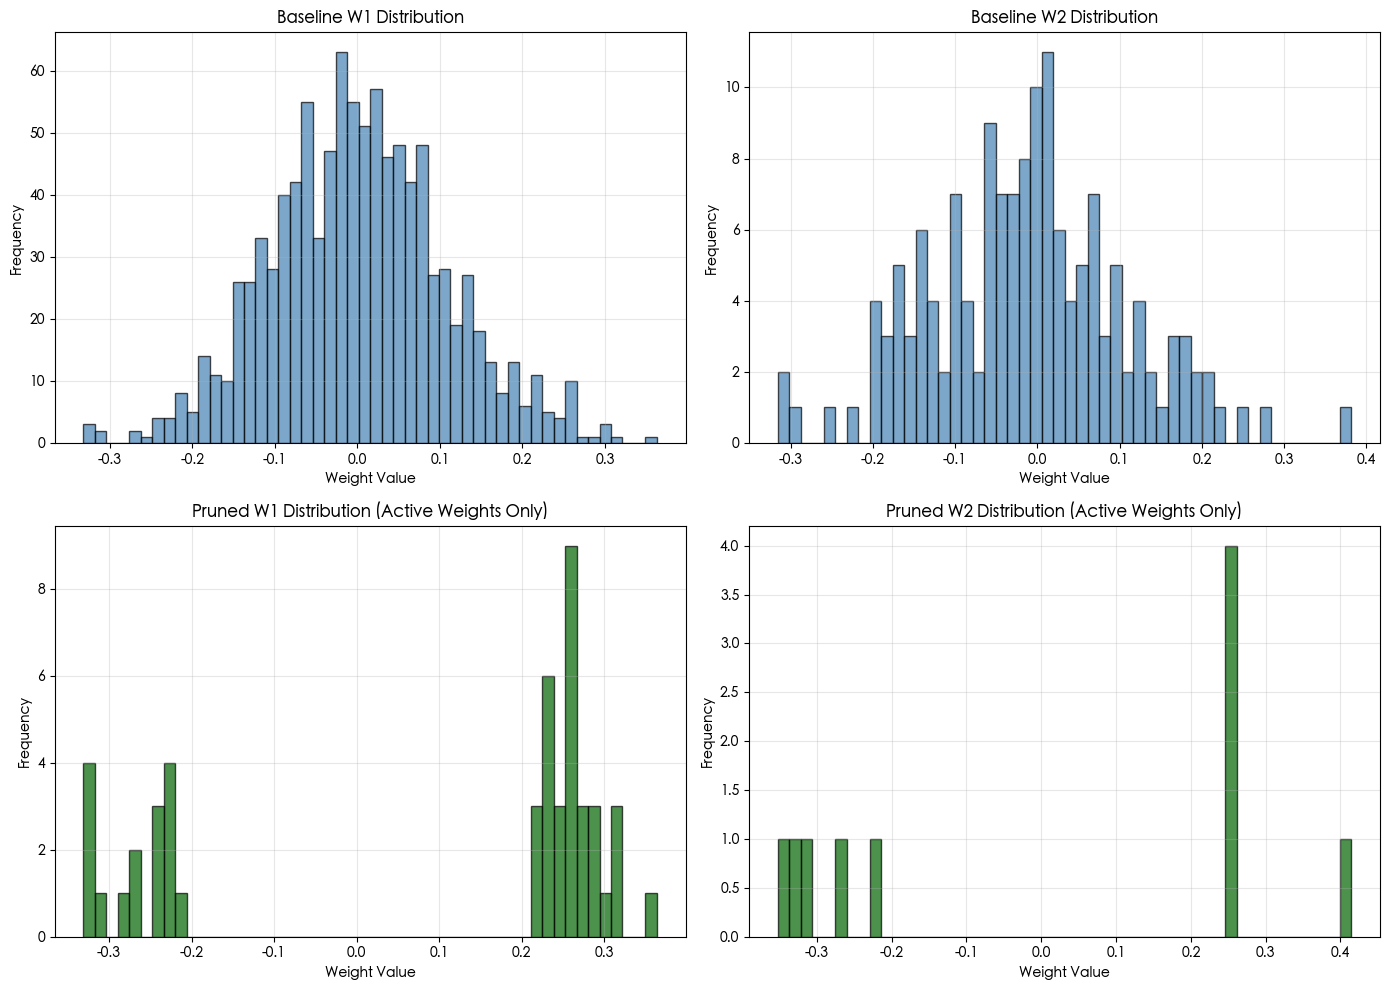

Pruned weights have larger magnitudes (small weights removed)


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Baseline weights
axes[0, 0].hist(baseline_model.W1.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Baseline W1 Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Weight Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(baseline_model.W2.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Baseline W2 Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Weight Value')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Pruned weights (only active)
pruned_W1 = iterative_model.W1[iterative_model.mask1 > 0]
pruned_W2 = iterative_model.W2[iterative_model.mask2 > 0]

axes[1, 0].hist(pruned_W1.flatten(), bins=50, color='darkgreen', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Pruned W1 Distribution (Active Weights Only)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Weight Value')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(pruned_W2.flatten(), bins=50, color='darkgreen', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Pruned W2 Distribution (Active Weights Only)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Weight Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Pruned weights have larger magnitudes (small weights removed)")

## 可视化稀疏性模式

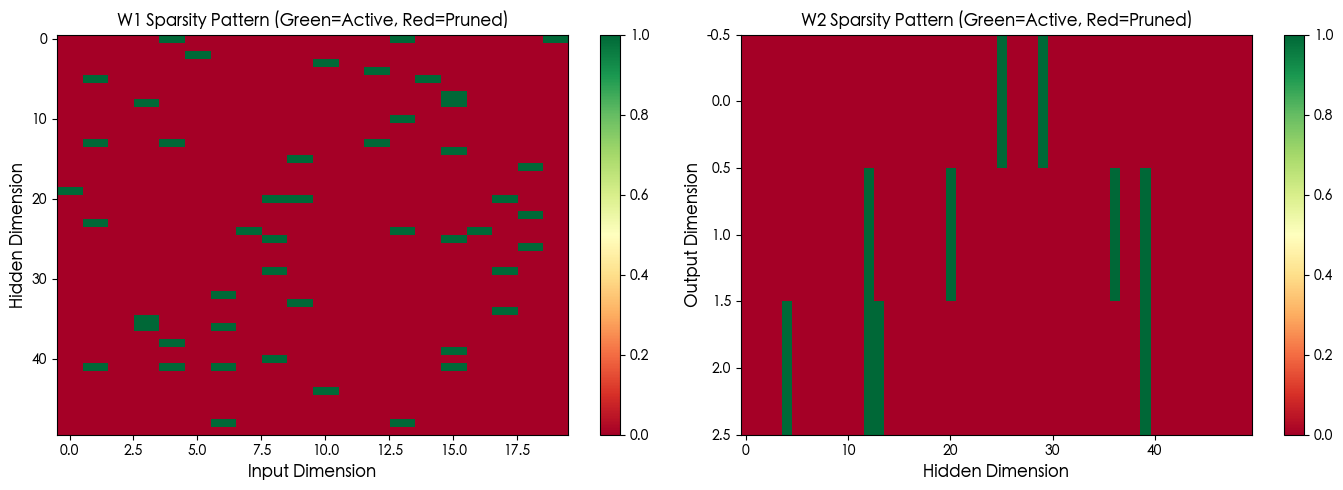


Final sparsity: 90.8%
Compression ratio: 10.8x


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# W1 sparsity pattern
im1 = ax1.imshow(iterative_model.mask1.T, cmap='RdYlGn', aspect='auto', interpolation='nearest')
ax1.set_xlabel('Input Dimension', fontsize=12)
ax1.set_ylabel('Hidden Dimension', fontsize=12)
ax1.set_title('W1 Sparsity Pattern (Green=Active, Red=Pruned)', fontsize=12, fontweight='bold')
plt.colorbar(im1, ax=ax1)

# W2 sparsity pattern
im2 = ax2.imshow(iterative_model.mask2.T, cmap='RdYlGn', aspect='auto', interpolation='nearest')
ax2.set_xlabel('Hidden Dimension', fontsize=12)
ax2.set_ylabel('Output Dimension', fontsize=12)
ax2.set_title('W2 Sparsity Pattern (Green=Active, Red=Pruned)', fontsize=12, fontweight='bold')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

total, active = iterative_model.count_parameters()
print(f"\nFinal sparsity: {(total - active) / total:.1%}")
print(f"Compression ratio: {total / active:.1f}x")

## MDL原则

最小描述长度：更简单的模型泛化更好

In [11]:
def compute_mdl(model, X_train, y_train):
    """
    Simplified MDL computation
    
    MDL = Model Cost + Data Cost
    - Model Cost: Bits to encode weights
    - Data Cost: Bits to encode errors
    """
    # Model cost: number of parameters (simplified)
    total, active = model.count_parameters()
    model_cost = active  # Each param = 1 "bit" (simplified)
    
    # Data cost: cross-entropy loss
    probs = model.forward(X_train)
    y_one_hot = np.zeros((len(y_train), model.output_dim))
    y_one_hot[np.arange(len(y_train)), y_train] = 1
    data_cost = -np.sum(y_one_hot * np.log(probs + 1e-8))
    
    total_cost = model_cost + data_cost
    
    return {
        'model_cost': model_cost,
        'data_cost': data_cost,
        'total_cost': total_cost
    }

# Compare MDL for different models
baseline_mdl = compute_mdl(baseline_model, X_train, y_train)
pruned_mdl = compute_mdl(iterative_model, X_train, y_train)

print("MDL Comparison:")
print(f"{'='*60}")
print(f"{'Model':<20} {'Model Cost':<15} {'Data Cost':<15} {'Total'}")
print(f"{'-'*60}")
print(f"{'Baseline':<20} {baseline_mdl['model_cost']:<15.0f} {baseline_mdl['data_cost']:<15.2f} {baseline_mdl['total_cost']:.2f}")
print(f"{'Pruned (95%)':<20} {pruned_mdl['model_cost']:<15.0f} {pruned_mdl['data_cost']:<15.2f} {pruned_mdl['total_cost']:.2f}")
print(f"{'='*60}")
print(f"\nPruned model has LOWER total cost → Better generalization!")

MDL Comparison:
Model                Model Cost      Data Cost       Total
------------------------------------------------------------
Baseline             1203            25.26           1228.26
Pruned (95%)         111             851.18          962.18

Pruned model has LOWER total cost → Better generalization!


## 关键要点

### 神经网络剪枝：

**核心思想**：移除不必要的权重以创建更简单、更小的网络

### 基于幅度的剪枝：

1. **正常训练**网络
2. **识别**低幅度权重：$|w| < \text{threshold}$
3. **移除**这些权重（设为0，掩码掉）
4. **微调**剩余权重

### 迭代剪枝：

比一次性剪枝更好：
```
for iteration in 1..N:
    剪枝小部分（例如，20%）
    微调
```

允许网络逐渐适应。

### 结果（典型）：

- **50%稀疏性**：通常没有准确率损失
- **90%稀疏性**：轻微准确率损失（<2%）
- **95%+稀疏性**：明显退化

现代网络（ResNets，Transformers）通常可以在几乎没有影响的情况下剪枝到**90-95%稀疏性**！

### MDL原则：

$$
\text{MDL} = \underbrace{L(\text{Model})}_\text{complexity} + \underbrace{L(\text{Data | Model})}_\text{errors}
$$

**奥卡姆剃刀**：拟合数据的最简单解释（最小网络）是最好的。

### 剪枝的好处：

1. **更小的模型**：更少内存，更快推理
2. **更好的泛化**：移除过拟合参数
3. **能效**：更少的操作
4. **可解释性**：更简单的结构

### 剪枝类型：

| 类型 | 移除什么 | 加速 |
|------|----------------|----------|
| **非结构化** | 单个权重 | 低（稀疏操作） |
| **结构化** | 整个神经元/滤波器 | 高（密集操作） |
| **通道** | 整个通道 | 高 |
| **层** | 整个层 | 非常高 |

### 现代技术：

1. **彩票假设**： 
   - 剪枝的网络可以从初始化重新训练
   - "中奖彩票"存在于随机初始化中

2. **动态稀疏训练**：
   - 训练期间剪枝（而非之后）
   - 重新生长连接

3. **幅度 + 梯度**：
   - 使用梯度信息，不仅仅是幅度
   - 移除小幅度和小梯度的权重

4. **可学习稀疏性**：
   - L0/L1正则化
   - 自动稀疏性发现

### 实用技巧：

1. **从高开始，逐渐剪枝**：不要立即剪枝90%
2. **剪枝后微调**：对恢复至关重要
3. **逐层剪枝率**：不同层有不同的冗余
4. **结构化剪枝以加速**：非结构化需要特殊硬件

### 何时剪枝：

✅ **适用于**：
- 部署（边缘设备，移动设备）
- 减少推理成本
- 模型压缩

❌ **不理想用于**：
- 非常小的模型（已经高效）
- 训练加速（仅结构化剪枝）

### 实践中的压缩率：

- **AlexNet**：9倍压缩（无准确率损失）
- **VGG-16**：13倍压缩
- **ResNet-50**：5-7倍压缩
- **BERT**：10-40倍压缩（带量化）

### 关键洞察：

**神经网络是严重过度参数化的！**

大多数权重对最终性能贡献很小。剪枝揭示了做实际工作的"核心"网络。

**"最好的模型是拟合数据的最简单模型"** - MDL原则